# Gamer AI for game BreakoutNoFrameskip-v4

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Checking GPU connection status

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Can\'t connect to GPU.')
else:
    print(gpu_info)

Sat Sep  9 03:43:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   59C    P8     3W /  N/A |    178MiB /  4096MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Initializing environment and installing dependencies

In [ ]:
!pip install stable-baselines[mpi]
#Download and install ROMs
!gdown -q http://www.atarimania.com/roms/Roms.rar
!pip install -q unrar
!mkdir ./roms_atari
!unrar x Roms.rar ./roms_atari
!pip install atari-py
!python -m atari_py.import_roms ./roms_atari

In [3]:
import os
import gym
from gym.wrappers import FrameStack
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from gym.wrappers.atari_preprocessing import AtariPreprocessing
from collections import deque
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

(210, 160, 3)


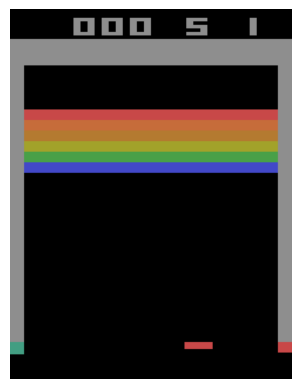

In [4]:
# Initializing environment
env = gym.make('BreakoutNoFrameskip-v4', render_mode='rgb_array')
obs = env.reset()
print(obs[0].shape)
plt.imshow(env.render())
plt.axis('off')
plt.show()

### Examining preprocessed environment

(84, 84, 4)


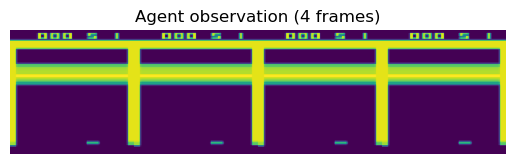

In [5]:
# Convert frames to Grayscale then rescale to (84,84)
env = AtariPreprocessing(env=env, screen_size=84, frame_skip=4, terminal_on_life_loss=True, scale_obs=True)
# Wrapping 4 frames into 1 line for model to learn the context of the environment at the same time
env = FrameStack(env=env, num_stack=4)
obs = np.array(env.reset()[0])

# Reshape shapre (C,H,W) to (H,W,C)
print(obs.transpose([1, 2, 0]).shape)
plt.title("Agent observation (4 frames)")
# Reshaping (C,H,W) to (H,C,W) then transfroming to (H, C*W)
plt.imshow(obs.transpose([1, 0, 2]).reshape([env.observation_space.shape[1], -1]))
plt.axis('off')
plt.show()

In [6]:
# Actions
print(env.action_space)
print(env.get_action_meanings())

Discrete(4)
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


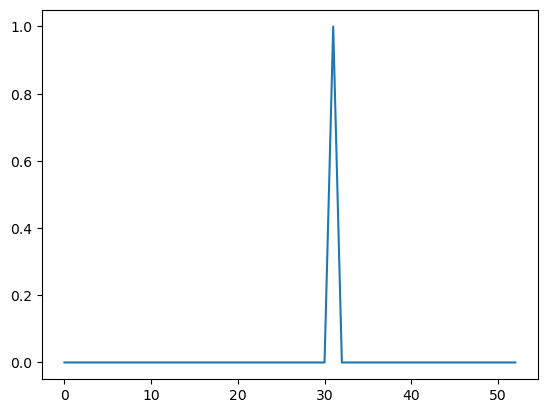

In [63]:
# Rewards
env.reset()
rewards = []
terminate = False
while not terminate:
    state, reward, terminate, truncated, info = env.step(env.action_space.sample())
    rewards.append(reward)
plt.plot(rewards)

### Build DQN model

In [4]:
class DNNModel():
    def __init__(
            self,
            action_size: int = 4,
    ) -> None:
        self.output_shape = action_size


    def built_model(self, default_compiler:bool=False):
        input_layer = Input(shape=(84, 84, 4,))
        layer1 = Conv2D(32, (8,8), strides=(4,4), activation="relu")(input_layer)
        layer2 = Conv2D(64, (4,4), strides=(2,2), activation="relu")(layer1)
        layer3 = Conv2D(64, (3,3), strides=(1,1), activation="relu")(layer2)
        layer4 = Flatten()(layer3)
        layer5 = Dense(512, activation='relu')(layer4)
        output_layer = Dense(self.output_shape, activation='linear')(layer5)
        model = Model(inputs=input_layer, outputs=output_layer)

        if default_compiler:
            model.compile(optimizer=Adam(), loss=Huber())
        return model

class DQN():
    def __init__(
            self, 
            env: gym.Env, 
            discount_factor: float = 0.99,
            learning_rate: float = 25e-5,
            initial_epsilon: float = 1.0,
            epsilon_decay: float = 2e-5,
            epsilon_min: float = 0.01,
            epsilon_random_frames: int = 50000
    ) -> None:
        self.env = env
        self.state_space = env.observation_space.shape
        self.action_space = env.action_space.n
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon = initial_epsilon
        self.epsilon_max = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.epsilon_random_frames = epsilon_random_frames
        self.main_model = DNNModel(self.action_space).built_model(default_compiler=True)
        self.target_model = DNNModel(self.action_space).built_model()
        self.max_memory_length = 100000
        self.memory = deque(maxlen=self.max_memory_length)

        self.main_model.summary()

        # self.target_model.set_weights(self.main_model.get_weights())

    def act(self, state, epsilon, time_steps):
        # Apply epsilon-greedy policy for picking the corresponding action
        if np.random.rand() < epsilon or time_steps < self.epsilon_random_frames:
            return np.random.randint(self.action_space)
        
        state_tensor = tf.convert_to_tensor(state)
        # Convert state_tensor with size (state_size,) to 1-batch state (num_batch, state_size) = (1, state_size)
        state_tensor = tf.expand_dims(state_tensor, axis=0)
        # Get Q values for correspoding actions predicted from model of the defined state
        q_value = self.main_model.predict(state_tensor)
        # Choose action with highest Q value from Q_values list with size (1, Q_values-actions_size)
        action = tf.argmax(q_value[0]).numpy()

        return action

    def update_epsilon(self, time_steps) -> None:
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min)*np.exp(-self.epsilon_decay*time_steps)
        
    def store_experience(self, state, reward, action, next_state, terminate:bool):
        self.memory.append((state, reward, action, next_state, terminate))

    def clip_reward(self, reward):
        # Bin reward to {+1, 0, -1} by its sign.
        clipped_reward = max(min(reward, 1.0), -1.0)
        return clipped_reward

    def get_experience_sample(self, batch_size):
        # Get sample batch from experience storage 
        experiecne_batch = random.sample(self.memory, batch_size)

        state_batch = np.array([batch[0] for batch in experiecne_batch])
        reward_batch = [batch[1] for batch in experiecne_batch]
        action_batch = [batch[2] for batch in experiecne_batch]
        next_state_batch = np.array([batch[3] for batch in experiecne_batch])
        terminate_batch = [batch[4] for batch in experiecne_batch]

        return state_batch, reward_batch, action_batch, next_state_batch, terminate_batch

    def fit(
            self, total_time_steps:int=100000, 
            max_time_steps:int=1000, 
            early_stopping:bool=False, 
            batch_size:int=32, 
            learning_starts:int=50000,
            update_main_model_freq:int=20, 
            update_target_model_freq:int=5000,
            reward_threshold:int=15,
            num_avg_episode_score:int=5,
            check_freq_callback:int=1000, 
            log_callback:bool=True
    ):
        # Setup GPU for training
        physical_devices = tf.config.list_physical_devices('GPU')
        if len(physical_devices) > 0:
            tf.config.set_visible_devices(physical_devices[0], 'GPU')
            print('GPU is available')
        else:
            print('GPU is not available')

        if not os.path.exists('./Results/'):
            os.makedirs('./Results/')

        epsiode_count = 0
        time_step_count = 0
        learning_starts_count = 0

        mean_running_reward = 0
        running_reward_per_episode_list = []
        episode_reward_limit = num_avg_episode_score

        optimizer = Adam(learning_rate=self.learning_rate, clipnorm=1.0)
        loss_function = Huber()

        # Mean running reward threshold for finishing training
        runing_reward_threshold = reward_threshold

        # Train model after a defined frequency
        update_model_frequency = update_main_model_freq

        # Update target model after a defined frequency
        update_target_model_frequency = update_target_model_freq

        print('Start training session..')

        while (time_step_count < total_time_steps)  or not early_stopping:
            terminate = False

            reward_episode = 0.0
            loss = 0

            # Initialize current state
            current_state = np.array(self.env.reset()[0]).transpose([1, 2, 0])

            for time_step in range(max_time_steps):
                # Get action
                current_action = self.act(current_state, self.epsilon, time_step_count)

                # Perform action
                next_state, reward, terminate, _, _ = self.env.step(current_action)
                # Clip reward
                reward = self.clip_reward(reward)
                # Reshape next state data
                next_state = np.array(next_state).transpose([1, 2, 0])
                reward_episode += reward

                # Store experience
                self.store_experience(current_state, reward, current_action, next_state, terminate)

                # Increment time step
                if learning_starts_count <= learning_starts:
                    learning_starts_count = learning_starts_count + 1
                else: 
                    time_step_count = time_step_count + 1

                # Experience replay if reach required time steps and experience batch memory
                if time_step_count % update_model_frequency == 0 and len(self.memory) > batch_size:
                    # Get epericence batch
                    state_batch, reward_batch, action_batch, next_state_batch, terminate_batch = self.get_experience_sample(batch_size)

                    # Get max Q value of next state
                    next_q_value = tf.reduce_max(self.target_model.predict(next_state_batch), axis=1)

                    # Get target reward (groundtruth)
                    # target_value = reward_batch if terminate_batch else reward_batch + self.discount_factor*next_q_value

                    # # Train model
                    # with tf.GradientTape() as tape:               
                    #     # Get all available Q values-actions of current state during feed-forward training session
                    #     current_q_value = self.main_model(state_batch)
                    #     # Create mask to filter only Q values of performed actions
                    #     mask = tf.one_hot(action_batch, self.action_space)
                    #     # Filter Q values
                    #     current_q_value = tf.reduce_sum(tf.multiply(current_q_value, mask), axis=1)
                    #     # Calculate loss function
                    #     loss = loss_function(target_value, current_q_value)

                    # # Backpropagation
                    # # Calculate gradient of loss function
                    # gradients = tape.gradient(loss, self.main_model.trainable_variables)
                    # # Apply gradients to update parameters
                    # optimizer.apply_gradients(zip(gradients, self.main_model.trainable_variables))
                    
                    current_q_value = self.main_model.predict(state_batch)
                    for i in range(batch_size):
                        target_value = -1 if terminate_batch[i] else reward_batch[i] + self.discount_factor*next_q_value[i]
                        current_q_value[i][action_batch[i]] = target_value

                    history = self.main_model.fit(state_batch, current_q_value, verbose=0)
                    loss = history.history['loss'][0]

                # Update target model after required time steps
                if time_step_count % update_target_model_frequency == 0 and time_step_count != 0:
                    self.target_model.set_weights(self.main_model.get_weights())
                    r1, r2, r3, r4, r5 = running_reward_per_episode_list[-5], running_reward_per_episode_list[-4], running_reward_per_episode_list[-3], running_reward_per_episode_list[-2], running_reward_per_episode_list[-1]
                    print(f'Mean running reward {mean_running_reward:.2f} - 5 latest total rewards {r1:.0f}-{r2:.0f}-{r3:.0f}-{r4:.0f}-{r5:.0f} - at episode {epsiode_count} of time step {time_step_count}\t- epsilon: {self.epsilon:.3f}\t- loss: {loss:e}')                   

                # Remove oldest eperience if memory is exceeded
                if len(self.memory) > self.max_memory_length:
                    self.memory.popleft()

                if terminate:
                    break

                # Update new epsilone
                self.update_epsilon(time_step_count)

                # Update current state
                current_state = next_state

                # Save callback models
                if log_callback and time_step_count % check_freq_callback == 0 and time_step_count != 0:
                    folder_path = './Results/'
                    model_name = str(time_step_count) + '_model.h5'
                    file_name = folder_path + model_name
                    self.save_model(file_name)
                    print(f'Model of {time_step_count} time steps is saved to ' + file_name)
            
            # Update mean running reward before checking stopping condition
            if learning_starts_count > learning_starts:
                running_reward_per_episode_list.append(reward_episode)
            # Remove oldest reward if memory is exceeded
            if len(running_reward_per_episode_list) > episode_reward_limit:
                del running_reward_per_episode_list[:1]
            if len(running_reward_per_episode_list) > 0:
                mean_running_reward = np.mean(running_reward_per_episode_list)

            if mean_running_reward > runing_reward_threshold and not early_stopping:
                print(f'Finished training with running reward {mean_running_reward} at episode {epsiode_count}.')
                break
            
            epsiode_count += 1

        if early_stopping:
            print(f'Finished training with running reward {mean_running_reward} at episode {epsiode_count}.')
        
        # Save model
        self.save_model('./Results/last_model.h5')
        print('Latest model is saved to ./Results/last_model.h5')

    def save_model(self, file_path):
        self.main_model.save(file_path)

    def load_model(self, file_path):
        self.main_model = load_model(file_path)

    def test_model(self, env:gym.Env, time_steps:int=4000, record:bool=True):
        if not os.path.exists('./Videos/') and record:
            os.mkdir('./Videos/')

        # Initialized Video recorder
        video = VideoRecorder(env, './Videos/demo.mp4')
        
        total_bricks = 108
        hits_list = []
        rewards_list = []

        epsilon_test = 0.01

        current_state = np.array(env.reset()[0]).transpose([1, 2, 0])

        for time_step in range(time_steps):
            # Record frame
            if record:
                video.capture_frame()

            # Get action
            current_action = self.act(current_state, epsilon_test, 1000000)

            # Perform action
            next_state, reward, terminate, _, info = env.step(current_action)

            # Clip reward
            reward = int(self.clip_reward(reward))
            rewards_list.append(reward) 
            hits_list.append(reward) 

            # Reshape next state data
            current_state = np.array(next_state).transpose([1, 2, 0])

            if terminate:
                bricks_left = total_bricks - np.sum(hits_list)
                print(f'Bricks left to be destroyed: {bricks_left}.')
                hits_list = []

                print(f'Lost 1 life at time step {time_step + 1}.')
                print(info)
                plt.plot(rewards_list, color="blue")
                plt.ylabel("Reward",color="blue",fontsize=14)
                plt.show()
                rewards_list = []

                if info['lives'] == 0:
                    break

        if record:
            video.close()

        env.close()

### Initialize preprocessed Atari environment

In [6]:
def Initialize_environment(game_name):
    env = gym.make(game_name, render_mode='rgb_array')

    # Convert frames to Grayscale then rescale to (84,84)
    env = AtariPreprocessing(env=env, frame_skip=4, terminal_on_life_loss=True, scale_obs=True)
    # Wrapping 4 frames into 1 line for model to learn the context of the environment at the same time
    env = FrameStack(env=env, num_stack=4)
     
    return env

### Train DQN model

In [7]:
# Initialize new environment
env = Initialize_environment('BreakoutNoFrameskip-v4')
# Initialize DQN model
model_3 = DQN(env=env, epsilon_decay=1e-6, learning_rate=0.00025, discount_factor=0.99, initial_epsilon=1.0)
# Train model
model_3.fit(total_time_steps=1000000, max_time_steps=10000, learning_starts=5000, batch_size=32, update_main_model_freq=20, update_target_model_freq=10000, num_avg_episode_score=100, check_freq_callback=10000, early_stopping=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 84, 84, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 512)               1606144   
                                                                 
 dense_1 (Dense)             (None, 4)                 2052  

### Test model

Bricks left to be destroyed: 102.
Lost 1 life at time step 206.
{'lives': 4, 'episode_frame_number': 825, 'frame_number': 4245875}


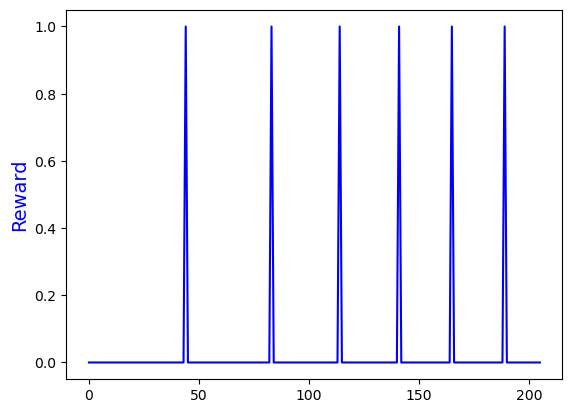

Bricks left to be destroyed: 104.
Lost 1 life at time step 494.
{'lives': 3, 'episode_frame_number': 1974, 'frame_number': 4247024}


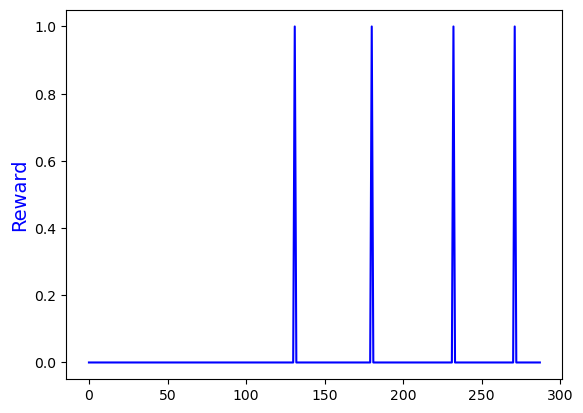

Bricks left to be destroyed: 104.
Lost 1 life at time step 874.
{'lives': 2, 'episode_frame_number': 3494, 'frame_number': 4248544}


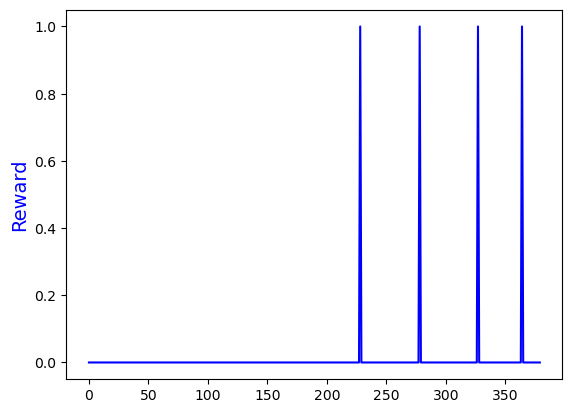

Bricks left to be destroyed: 107.
Lost 1 life at time step 926.
{'lives': 1, 'episode_frame_number': 3700, 'frame_number': 4248750}


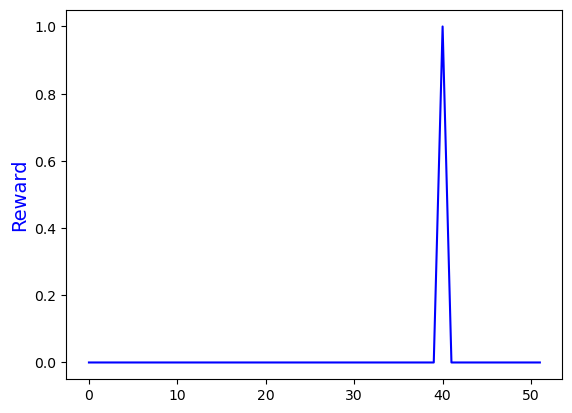

Bricks left to be destroyed: 99.
Lost 1 life at time step 1243.
{'lives': 0, 'episode_frame_number': 4967, 'frame_number': 4250017}


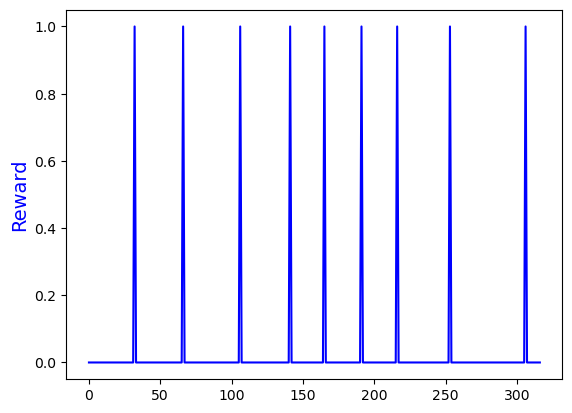

Moviepy - Building video ./Videos/demo.mp4.
Moviepy - Writing video ./Videos/demo.mp4



Moviepy - Done !
Moviepy - video ready ./Videos/demo.mp4


In [10]:
model_3.test_model(env=env, record=True)

In [12]:
# Initialize new environment
env = Initialize_environment('BreakoutNoFrameskip-v4')
# Initialize model
inference_model = DQN(env=env)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 84, 84, 4)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 32)        8224      
                                                                 
 conv2d_7 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 3136)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1606144   
                                                                 
 dense_5 (Dense)             (None, 4)                 2052

Bricks left to be destroyed: 101.
Lost 1 life at time step 240.
{'lives': 4, 'episode_frame_number': 963, 'frame_number': 4617}


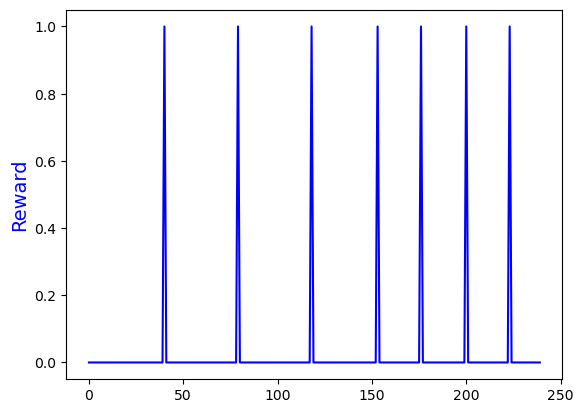

Bricks left to be destroyed: 105.
Lost 1 life at time step 378.
{'lives': 3, 'episode_frame_number': 1514, 'frame_number': 5168}


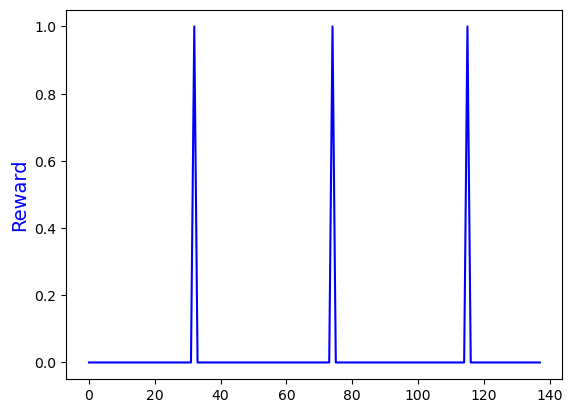

Bricks left to be destroyed: 104.
Lost 1 life at time step 621.
{'lives': 2, 'episode_frame_number': 2484, 'frame_number': 6138}


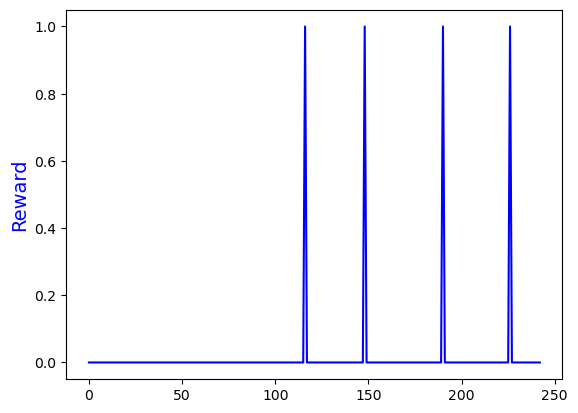

Bricks left to be destroyed: 106.
Lost 1 life at time step 711.
{'lives': 1, 'episode_frame_number': 2843, 'frame_number': 6497}


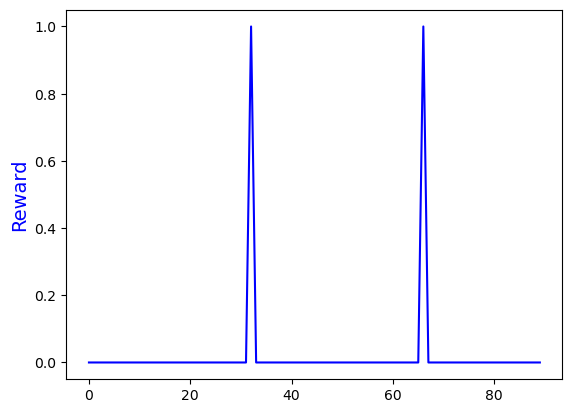

Bricks left to be destroyed: 104.
Lost 1 life at time step 893.
{'lives': 0, 'episode_frame_number': 3569, 'frame_number': 7223}


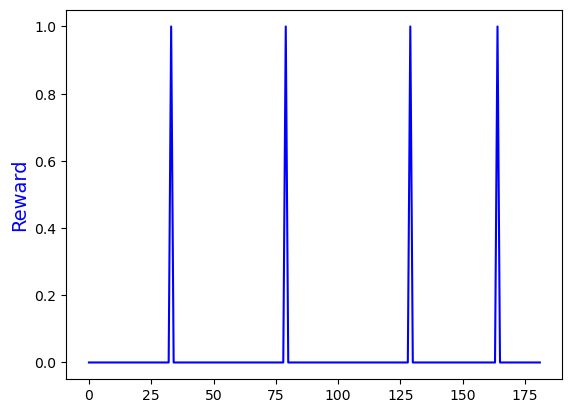

Moviepy - Building video ./Videos/demo.mp4.
Moviepy - Writing video ./Videos/demo.mp4



Moviepy - Done !
Moviepy - video ready ./Videos/demo.mp4


In [14]:
# Load model
inference_model.load_model('./Results/920000_model.h5')
# Test model
inference_model.test_model(env=env, record=True)